# Gym Subscription Length project
## by Jeshua Perzabal

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor

In [4]:
data = pd.read_csv("data.csv")
data.head()

,person_id,date_of_birth,gender,over_30k_income_prob,gym_id,gym_opening_date,gym_segment,subscription_id,subscription_start_date,subscription_end_date,joiner_type,product_group,first_visit_date,first_class_attend_date
0,5047057,2000-08-01,MALE,0.8990,598,2015-09-01,Town Centre,NaN,2018-01-09,NaN,New Joiner,Product A,2018-01-09,NaN
1,5089802,1997-02-11,FEMALE,NaN,598,2015-09-01,Town Centre,NaN,2018-01-16,2018-06-15,New Joiner,Product A,2018-01-16,2018-01-19
2,4941945,2001-11-24,FEMALE,0.9200,598,2015-09-01,Town Centre,NaN,2018-01-22,2021-07-21,New Joiner,Product A,2018-01-25,NaN
3,3318296,1994-08-04,FEMALE,0.9208,598,2015-09-01,Town Centre,NaN,2018-01-23,2018-04-24,Rejoiner,Product A,NaN,NaN
4,5078930,2001-07-05,MALE,0.8000,598,2015-09-01,Town Centre,NaN,2018-01-14,2018-08-13,New Joiner,Product A,2018-01-15,NaN


In [5]:
data.info()
data.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38266 entries, 0 to 38265
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   person_id                38266 non-null  int64  
 1   date_of_birth            38266 non-null  object 
 2   gender                   38266 non-null  object 
 3   over_30k_income_prob     37169 non-null  float64
 4   gym_id                   38266 non-null  int64  
 5   gym_opening_date         38266 non-null  object 
 6   gym_segment              38266 non-null  object 
 7   subscription_id          0 non-null      float64
 8   subscription_start_date  38266 non-null  object 
 9   subscription_end_date    37047 non-null  object 
 10  joiner_type              38266 non-null  object 
 11  product_group            38266 non-null  object 
 12  first_visit_date         34554 non-null  object 
 13  first_class_attend_date  8727 non-null   object 
dtypes: float64(2), int64(2

,person_id,date_of_birth,gender,over_30k_income_prob,gym_id,gym_opening_date,gym_segment,subscription_id,subscription_start_date,subscription_end_date,joiner_type,product_group,first_visit_date,first_class_attend_date
count,3.826600e+04,38266,38266,37169.000000,38266.000000,38266,38266,0.0,38266,37047,38266,38266,34554,8727
unique,NaN,11618,2,NaN,NaN,7,4,NaN,364,1157,3,4,496,663
top,NaN,1980-01-01,MALE,NaN,NaN,2014-03-02,Town Centre,NaN,2018-03-11,2031-01-18,New Joiner,Product A,2018-03-12,2018-01-29
freq,NaN,18,19990,NaN,NaN,8078,14419,NaN,530,252,24008,31332,342,63
mean,4.695588e+06,NaN,NaN,0.615329,600.830973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.377661e+06,NaN,NaN,0.189932,1.913651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4.657100e+04,NaN,NaN,0.000000,598.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.165286e+06,NaN,NaN,0.450000,599.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.217150e+06,NaN,NaN,0.636400,601.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.626650e+06,NaN,NaN,0.770000,602.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can observe that the dates do not have the appropriate format (they are read as strings) and that there are some features with null values within the data. Also `subscription_id` does not seem to have any data whatsoever. We also notice that all non-date categorical features have a low cardinality.

### Convert to appropriate data types for better handling

We will start by converting the dates to `np.datetime64` so they are more easily handled and we can have more information (such as the first and last date, etc). Also we can will list all of the other categorical features that are not dates to see what they are referring to as well as how are they distributed.<br>

In [6]:
date_columns = ["date_of_birth", "gym_opening_date", "subscription_start_date", "subscription_end_date", "first_visit_date", "first_class_attend_date"]
for feature in date_columns:
    data[feature] = pd.to_datetime(data[feature])
    
data["gym_id"] = data["gym_id"].astype("str") # gym_id, although it is numeric, is more like a tag for a particular gym. Since we don't care about the order of these ids, converting it to string will help us determine how many gyms do we have in total    
for feature in data.columns:
    if data[feature].dtype == "object":
        display(data[feature].value_counts())
        print("") #So the output is more readable
data[date_columns].describe(datetime_is_numeric=True)

MALE      19990
FEMALE    18276
Name: gender, dtype: int64

599    8078
601    7044
600    5451
604    4774
603    4674
598    4194
602    4051
Name: gym_id, dtype: int64

Town Centre                       14419
Small Retail Park / Standalone    11718
London Residential                 8078
Large Retail Park                  4051
Name: gym_segment, dtype: int64

New Joiner    24008
Rejoiner      11440
Transfer       2818
Name: joiner_type, dtype: int64

Product A    31332
Product D     2839
Product B     2433
Product C     1662
Name: product_group, dtype: int64

,date_of_birth,gym_opening_date,subscription_start_date,subscription_end_date,first_visit_date,first_class_attend_date
count,38266,38266,38266,37047,34554,8727
mean,1989-10-18 10:00:15.428840192,2014-06-03 12:21:31.506820864,2018-06-07 18:04:41.105942528,2019-01-18 11:48:07.521256704,2018-06-13 16:20:45.216183296,2018-07-15 08:21:27.040219904
min,1900-03-17 00:00:00,2013-12-16 00:00:00,2018-01-01 00:00:00,2018-01-07 00:00:00,2018-01-01 00:00:00,2018-01-02 00:00:00
25%,1985-05-29 06:00:00,2014-01-04 00:00:00,2018-03-07 00:00:00,2018-07-03 00:00:00,2018-03-10 00:00:00,2018-03-18 00:00:00
50%,1992-04-23 00:00:00,2014-03-02 00:00:00,2018-05-28 00:00:00,2018-10-31 00:00:00,2018-06-04 00:00:00,2018-06-29 00:00:00
75%,1997-01-10 00:00:00,2015-03-02 00:00:00,2018-09-17 00:00:00,2019-03-23 00:00:00,2018-09-19 00:00:00,2018-10-12 00:00:00
max,2002-12-16 00:00:00,2015-09-01 00:00:00,2018-12-30 00:00:00,2031-01-18 00:00:00,2020-02-18 00:00:00,2021-08-24 00:00:00


We can see here that there is no overlap between the earliest `subscription_start_date` and the latest `gym_opening_date`, therefore making sure that all subscriptions start after their corresponding gym was opened, thus validating that part of the data. Further validation regarding the overlaping of these dates will be done later.

## Data cleaning

In [7]:
data.drop_duplicates(subset=["person_id", "joiner_type"], inplace=True) #We remove duplicates by taking into account the joiner_type since a single person can join, rejoin and transfer once (for simplicity, let's assume that is the case for transfer)

### Creating new features

First thing we have to do is trying to determine any type of information that can be useful from the date features. I suspect that the date features by themselves are not that useful because I don't think it helps to know about the exact points in time where the events referred to by those dates take place; the intervals between those dates in the present is what I believe matters the most.


In [8]:
data["has_attended_class"] = False
data.loc[data["first_class_attend_date"].notna(), "has_attended_class"] = True

data["has_visited"] = False
data.loc[data["first_visit_date"].notna(), "has_visited"] = True

#I believe it is safe to assume that a missing `subscription_end_date` means that the subscription is still active since the record for ending the subscription doesn't exist
data["subscription_active"] = False
data.loc[(data["subscription_end_date"].isna()) | (data["subscription_end_date"] > np.datetime64("Today")), "subscription_active"] = True 

In [9]:
data["age"] = (np.datetime64("Today") -data["date_of_birth"]) /np.timedelta64(1, "Y") #To calculate age
data["age"] = data["age"].astype("int") #To floor the ages so we don't end up with decimals

data["gym_age_months"] = (np.datetime64("Today") -data["gym_opening_date"]) /np.timedelta64(1, "M") # Looking at the date table above, we see that all opening dates take a span of 2 years, so months seems like a good metric
data["gym_age_months"] = data["gym_age_months"].astype("int") #To floor the gym ages so we don't end up with decimals

data.loc[(data["subscription_end_date"].isna()) | (data["subscription_end_date"] == data["subscription_end_date"].max()), "subscription_end_date"] = np.datetime64("Today") # We set non existing subscriptions and the ones with the maximum date to today, so that we know the length until today

data["subscription_length"] = (data["subscription_end_date"] - data["subscription_start_date"]) / np.timedelta64(1, "M") #To convert to months

### Income probability over 30k

The only column that still has missing values is `over_30k_income_prob`. So, for all missing values in this feature we will impute <b>.5</b> to represent the case when we don't know (the customer has an <b>equal chance</b> of having an income over 30K than below 30k). I don't want to make it categorical since I think that might lead to some information loss.

In [10]:
data.loc[data["over_30k_income_prob"].isna(), "over_30k_income_prob"] = .5

### Drop the features with no more useful information

In [11]:
data.drop(columns=date_columns, inplace=True) # Drop the columns with dates
data.drop(columns=["subscription_id", "person_id"], inplace=True) # 'person_id' does not contain any valuable information (id_column) and 'subscription_id' does not contain any information at all

<i>Note: I still don't get rid of </i>`person_id`<i> since I suspect it might be useful for further feature engineering. I also thought about removing the duplicates based on a `person_id` but realized that because of the `joiner_type` feature is a little bit more complicated than it seems and would require a little bit of further exploration (having to make sure some dates align with the 'Transfer' value and such)</i>

In [12]:
data.info()
data.describe(include="all", datetime_is_numeric=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36869 entries, 0 to 38265
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                36869 non-null  object 
 1   over_30k_income_prob  36869 non-null  float64
 2   gym_id                36869 non-null  object 
 3   gym_segment           36869 non-null  object 
 4   joiner_type           36869 non-null  object 
 5   product_group         36869 non-null  object 
 6   has_attended_class    36869 non-null  bool   
 7   has_visited           36869 non-null  bool   
 8   subscription_active   36869 non-null  bool   
 9   age                   36869 non-null  int32  
 10  gym_age_months        36869 non-null  int32  
 11  subscription_length   36869 non-null  float64
dtypes: bool(3), float64(2), int32(2), object(5)
memory usage: 2.6+ MB


,gender,over_30k_income_prob,gym_id,gym_segment,joiner_type,product_group,has_attended_class,has_visited,subscription_active,age,gym_age_months,subscription_length
count,36869,36869.000000,36869,36869,36869,36869,36869,36869,36869,36869.000000,36869.000000,36869.000000
unique,2,NaN,7,4,3,4,2,2,2,NaN,NaN,NaN
top,MALE,NaN,599,Town Centre,New Joiner,Product A,False,True,False,NaN,NaN,NaN
freq,19229,NaN,7871,13890,24008,30136,28379,33383,35416,NaN,NaN,NaN
mean,NaN,0.612902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.866582,91.996121,8.015649
std,NaN,0.188206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.930155,6.984290,10.165371
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.000000,77.000000,0.032855
25%,NaN,0.455400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,83.000000,1.971293
50%,NaN,0.630000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,95.000000,4.008296
75%,NaN,0.767700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.000000,97.000000,9.067948


We can observe that the range of `subscription_lenght` includes plausible values (no negative numbers and as mentioned before, no subscriptions longer than existing gym ages), which means that no additional cleaning is needed. Also, `age` seems to have a lot of outliers in the data; the interquartile range for it is 11 and if we assume a margin of 1.5 for outliers, that would give us that the cut off age should be 54. While people excersising above 54 years old still looks reasonable, it seems unreasonable that people over 100 years old are using the facilities. Data visualizations should provide better information regarding this.

## Data analysis

### Distribution of subscription_length

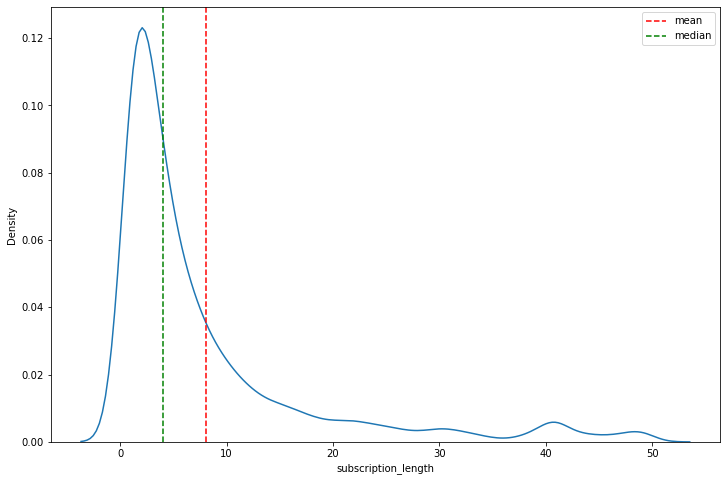

In [13]:
plt.figure(figsize=(12,8))
sns.kdeplot(data["subscription_length"])
plt.axvline(data["subscription_length"].mean(), label="mean", linestyle="--", color="r")
plt.axvline(data["subscription_length"].median(), label="median", linestyle="--", color="g")
plt.legend()
plt.show()

We can see that most subscriptions last between 0 and 5 months and that the distribution is skewed to the right with many outliers that I suspect represent loyal customers.

In [14]:
def plot_and_correlate(data, dependant_variable, exclude=[], num_plot_columns=3):
    if dependant_variable not in exclude:
        exclude.append(dependant_variable)
    num_plot_rows = ((data.shape[1] - len(exclude) - 1)// num_plot_columns) + 1 # To automatically detect how many rows does the plot require (we substract 1 to account for where mod=0)
    print(data.shape[1], num_plot_rows, num_plot_columns)
    f, axes = plt.subplots(num_plot_rows, num_plot_columns, figsize=(30,5*num_plot_rows)) #Because we are going to plot 12 features: 4 rows, 3 columns and we want the height of the plots to be independent of the number of rows
    row = 0
    column = 0
    
    if axes.ndim == 1:
        axes.shape = (1, axes.shape[0])
    for feature in data.columns:
        
        if feature not in exclude: 
            if data[feature].dtype == "object" or data[feature].dtype == "bool":
                sns.boxplot(x=dependant_variable, y=feature, data=data, orient="h", showmeans=True, ax=axes[row % num_plot_rows][column % num_plot_columns])
                axes[row % num_plot_rows][column % num_plot_columns].set_ylabel(feature)
                axes[row % num_plot_rows][column % num_plot_columns].set_xlabel(dependant_variable) 
                                
            else:
                sns.scatterplot(x=data[feature], y=data[dependant_variable], ax=axes[row % num_plot_rows][column % num_plot_columns])
                xlabel = "{0} - Pearson R: {1}".format(feature, pearsonr(data[feature], data[dependant_variable])[0]) #We are only interested in the pearson coefficient and not in the p-value
                axes[row % num_plot_rows][column % num_plot_columns].set_xlabel(xlabel)
                axes[row % num_plot_rows][column % num_plot_columns].set_ylabel(dependant_variable)
            
            column+=1
            if column % num_plot_columns == 0: 
                row += 1 
    plt.show()               
    

12 4 3


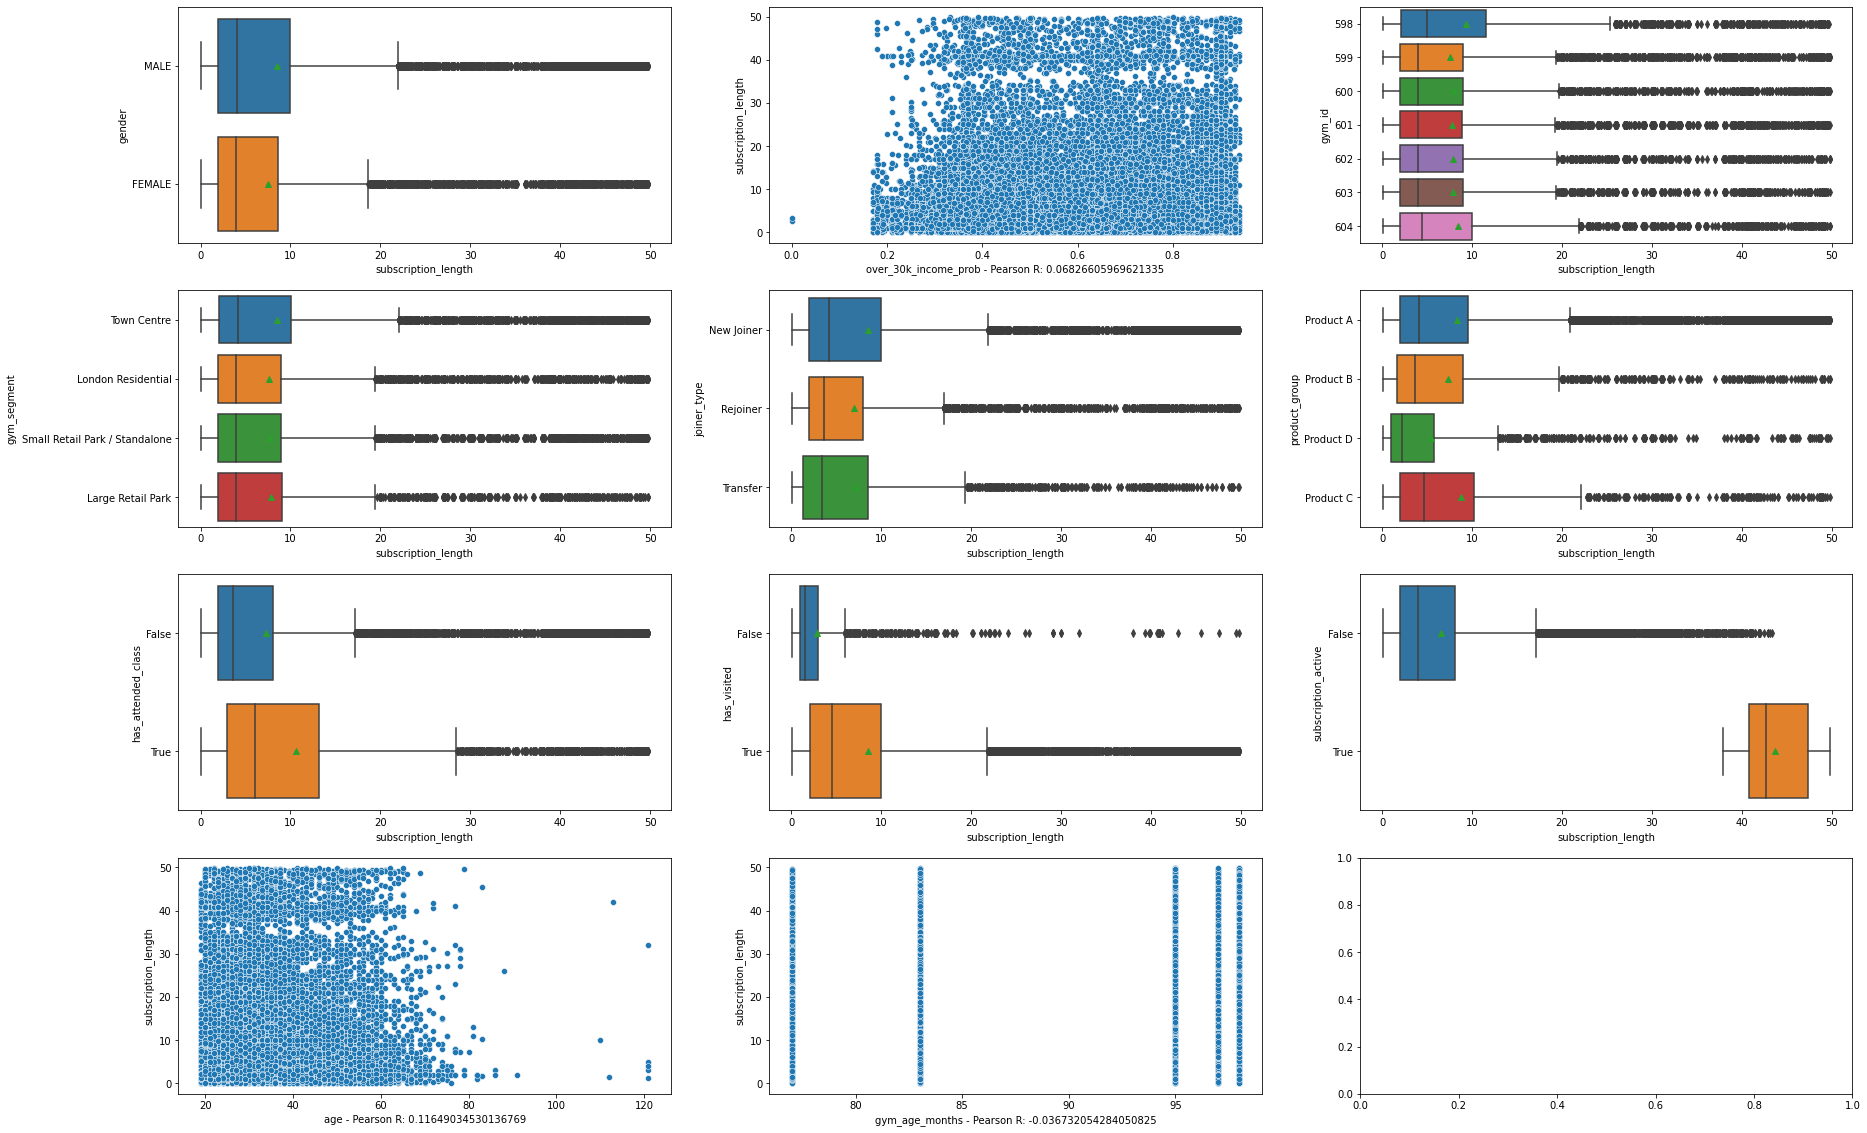

In [15]:
plot_and_correlate(data, "subscription_length", exclude=["person_id"])

In [16]:
data[["gym_id", "gym_segment", "gym_age_months"]].groupby(by=["gym_id", "gym_segment", "gym_age_months"]).size() # Data about each gym and the number of subscriptions

gym_id  gym_segment                     gym_age_months
598     Town Centre                     77                4056
599     London Residential              95                7871
600     Town Centre                     83                5243
601     Small Retail Park / Standalone  97                6773
602     Large Retail Park               98                3876
603     Small Retail Park / Standalone  95                4459
604     Town Centre                     95                4591
dtype: int64

Although relationships are very fuzzy do to the large number of outliers, thanks to teh boxplot we can notice that some trends can be observe in certain features:<br>
<u>`gym_id`, `gym_segment` and `gym_age_months`</u>: <i>Town Center</i> gyms seem to have on average more subscriptions and by looking at the `gym_id` boxplot, all 3 of them seem to have very similar medians. However we can see that there seem to be longer subscriptions on gym <i>598</i>. As shown by the `gym_age_months` boxplot and the pearson r, there seems to be no correlation between how old a gym is with the lenght of the subscription.<br>

<u>`joiner_type`</u>: Judging by the boxplot, <i>New joiners</i> tend to be suscribed for longer than <i>Rejoiners</i> and <i>Transfers</i>, however this would depend a lot on whether we count <i>Transfers</i> as extensions of existing subscriptions or on their own. I am realizing that it might make sense to add all `subscription_lengths` for users regardless of the type of joiner they are but to keep this excersise brief I will not do it.

<u>`product_group`</u>: Not entirely sure exactly what this feature is about but from the boxplot I can tell that <i>Product D</i> seems to have the lower `subscription_length` with both the mean and the median far behind the other categories.

<u>`has_attended_class`, `has_visited`and `subscription_active`</u>: By looking at the `has_visited` boxplot, it seems clear that users that tend to actually visit the gym seem to have longer subscriptions. A similar thing occurs for `has_attended_class`, with both the mean and the median subscription length being noticeably higher than `has_visited` for the ones that have attended, but the overlap between groups been higher too (the effect is weaker here). As for `subscription_active`, at first glance it would seem to be a good indicator, actually too good to be true. The fact that in order to create this variable we need the `subscription_end_date` means <b>we cannot use it for prediction</b>, since knowing when a user would quit is what we are trying to predict. However we can see that in general, users that suscribed more than 35 months ago are not likely to be quitting. This makes me think that maybe there was more value in `subscription_start_date` than I initially thought, however for the sake of keeping this excersise brief I will not do it.

<u>`over_30k_income_prob` and `age`</u>: In both of these features, there clearly seems to be outliers. On `over_30k_income_prob`, <i>0.0</i> probability of having an income over 30K is a very isolated value, with the cutoff seeming to be way higher than that while the cutoff for `age` seems to be clearly anything above <i>100</i> years old. Also, while `age` seems to have a faint positive linear correlation, the `over_30k_income_prob` doesn't seem to have one at all. Perhaps removing outliers will help a bit.<br>

<u>`subscription_start_month`</u>: Even though we are seeing a very low pearson R for this feature, we can clearly see a trend that as the year keeps moving forward, the length of subscriptions starts to diminish. I have to say that I only thought of this feature at the last minute.


In [17]:
data.loc[data["over_30k_income_prob"] < .1, "over_30k_income_prob"].shape[0] / data.shape[0]

5.4246114622040194e-05

In [18]:
data.loc[data["age"] > 100, "age"].shape[0] / data.shape[0]

0.00021698445848816078

In [19]:
# The percentage of samples within that designated outlier threshold for both features is really low, so we proceed to remove them since they are not likely to impact the data negatively
data.drop(labels=data[data["over_30k_income_prob"] < .1].index, inplace=True)
data.drop(labels=data[data["age"] > 100].index, inplace=True)

12 1 2


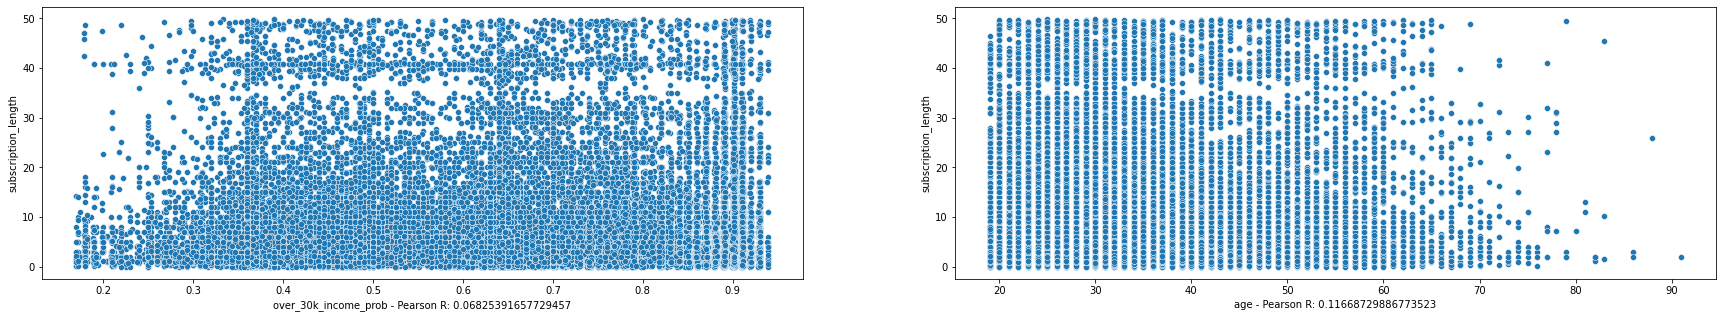

In [20]:
plot_and_correlate(data, "subscription_length", exclude=np.setdiff1d(data.columns, ["age", "over_30k_income_prob"]), num_plot_columns=2)

By removing the outliers, we can see that the pearson correlation for `age` became slitghlty larger, but it almost did not affect `over_30k_income_prob`. This means that `age` could actually be a decent predictor while the income not so much

## Model development

For model training, I will train a <b>Random Forest Regressor</b> since it is a very powerful model that requires little to no tuning and it has a simple way of estimating "feature importances" that helps make the model more explainable.<br>
The metric used for evaluation will be <b>Mean Absolute Error</b>. This metric is selected for 2 reasons:
- It gives us an easy to understand metric of error for non-technical people (the result will tell us by how many months we got the result wrong).
- It will not penalize outliers too much. This is good because if we look at the distribution of the dependent variable, we can observe that we have a lot of them.

In [21]:
X = data[np.setdiff1d(data.columns, ["person_id", "subscription_active", "subscription_length"])] #Remove the predictive variable as well as the features that may cause data leakage or are not useful
y = data["subscription_length"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0) # Creating a test set to test for generalization error later

In [22]:
cat_features = [x for x in X.columns if X[x].dtype == "object"]

training_steps = [    
    ("Encoder", ColumnTransformer(transformers=[("LabelEncoder", OrdinalEncoder(), cat_features)], remainder="passthrough")), #We need to label encode the categorical features. Other types of encoding such as OneHotEncoding could be applied at this level
    ("RandomForest", RandomForestRegressor()) #'absolute-error' split criteria takes a long time to compute
]
parameters = {
    "RandomForest__n_estimators" : [100,300,500,1000],
    "RandomForest__min_samples_split" : [2,50,100,200,500] # To control overfitting
}
rf_pipeline = Pipeline(steps=training_steps)

In [23]:
grid = GridSearchCV(estimator=rf_pipeline, param_grid=parameters, scoring=make_scorer(mean_absolute_error, greater_is_better=False), verbose=3)
grid.fit(X_train, y=y_train)
grid.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=-7.193 total time=   5.2s
[CV 2/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=-7.245 total time=   5.6s
[CV 3/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=-7.236 total time=   5.2s
[CV 4/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=-7.191 total time=   5.0s
[CV 5/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=-7.246 total time=   5.0s
[CV 1/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=300;, score=-7.192 total time=  15.4s
[CV 2/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=300;, score=-7.230 total time=  16.3s
[CV 3/5] END RandomForest__min_samples_split=2, RandomForest__n_estimators=300;, score=-7.223 total time=  16.9s
[CV 4/5] END RandomForest__min_sam

{'RandomForest__min_samples_split': 200, 'RandomForest__n_estimators': 1000}

In [28]:
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
rf_pipeline.set_params(RandomForest__n_estimators=1000, RandomForest__min_samples_split=200)
rf_pipeline.fit(X_train, y_train)
y_preds = rf_pipeline.predict(X_test)

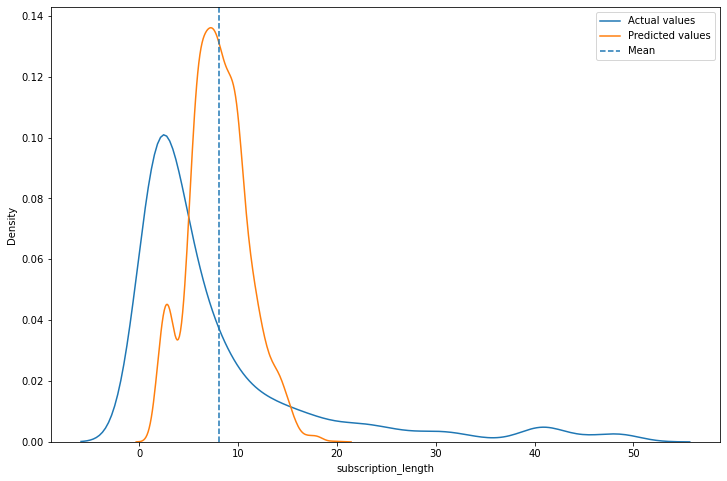

In [29]:
plt.figure(figsize=(12,8))
ax= sns.kdeplot(y_test, label="Actual values")
sns.kdeplot(rf_pipeline.predict(X_test), label="Predicted values", ax=ax)
plt.axvline(y_test.mean(), label="Mean", linestyle="--")
plt.legend()
plt.show()

In [30]:
print("MAE Baseline:", mean_absolute_error(y_test, baseline.predict(X_test))) 
print("MAE Training:", mean_absolute_error(y_train, rf_pipeline.predict(X_train))) #Results on training data
print("MAE Test:", mean_absolute_error(y_test, y_preds)) #Results on test data
pd.DataFrame(rf_pipeline.named_steps.RandomForest.feature_importances_, index=X.columns, columns=["Importance"])

MAE Baseline: 7.00544081312272
MAE Training: 6.366351308697008
MAE Test: 6.602884604918056


,Importance
age,0.061188
gender,0.029241
gym_age_months,0.023368
gym_id,0.034992
gym_segment,0.040990
has_attended_class,0.230907
has_visited,0.018134
joiner_type,0.100888
over_30k_income_prob,0.206214
product_group,0.254079


We can see that the model performance is consitent with a very slight indication of overfit and that it does perform better than our baseline (the mean of all data). We can also observe that the distribution is slightly displaced and centered around the mean, overestimating the time some members would be part of the gym (high bias). The solution to this might be to discover more features to the data to reduce the bias. It might also be worth to explore memebers in the outlier group (30-20 month subscription) in more depth and get more information about them.<br>
Also, we can see that according to the feature importances of the model, `product_group` is the best predictive feature, followed by `has_attended_class`. This goes more or less in line with our findings in saying that whatever <i>Product D</i> is, customers that are part of that group stay for a shorter period of time. `over_30k_income_prob` was a surprisingly strong predictor despite having a relatively low pearson R, which leads me to think that we might benefit from categorizing its values. Also it might be a good idea to do a partial dependance plot to determine in which direction the `subscription_length` goes when the probability of having an income of over 30 K changes.

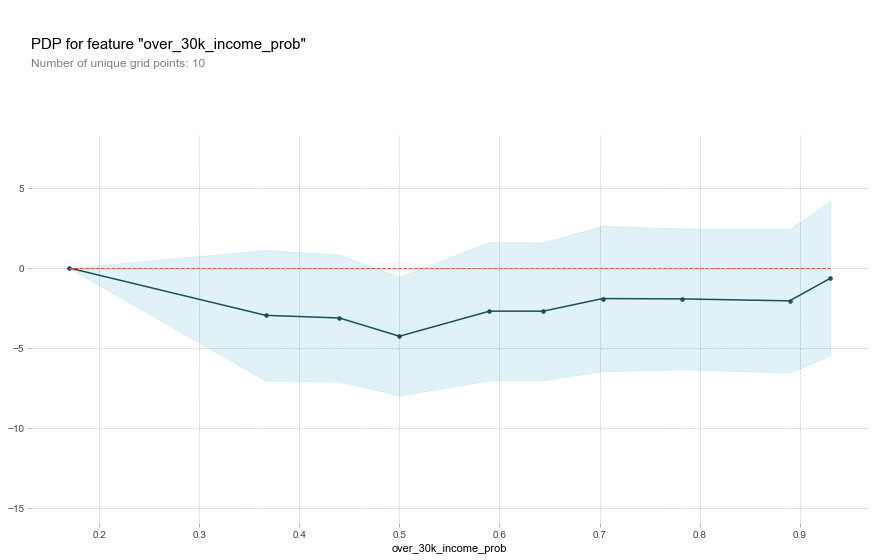

In [31]:
from pdpbox import pdp

pdp_income = pdp.pdp_isolate(rf_pipeline, X_test, X.columns, "over_30k_income_prob")
pdp.pdp_plot(pdp_income, "over_30k_income_prob")
plt.show()

Here we can observe that, interestingly enough, people with a low `over_30k_income_prob` (people with high probability of earing 30K and  below) tend to give longer subscriptions than people with a less certain `over_30k_income_prob`, with the lowest predictions in `subscription _length` happening when the probability is .5 (very uncertain). However it is worth noting that members with `over_30k_income_prob` tend to have a `subscription_lenght` of almost the same length as the other extreme. 